In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from patsy import dmatrices
import statsmodels.api as sm

In [2]:
## Todo: Make new 'full pipeline' version of this with 'curls' and stuff.

## Analysis 1: Opinion

Climate opinions show a severe 'this wont affect me' bias in three ways: they think other people should do more about it, they think it will harm the us but not them, they think corporations should do more about it than citizens, to a lesser extent they think the government should do more about it too.

This dataset is county-level from the Yale Climate Climate Communications project measured in 2021.

https://climatecommunication.yale.edu/visualizations-data/ycom-us/

In [42]:
opinions = pd.read_csv('YCOM6.0_2021_Data_.csv.new')

In [43]:
# Drop states, districts, etc
opinions = opinions.loc[opinions['GeoType'] == 'County']

In [44]:
# Drop descriptive columns
opinions = opinions.drop(['GeoType', 'GeoName'], axis=1)

In [45]:
# Fix the parsing of GEOID
opinions = opinions.assign(
    StateFIPS = opinions['GEOID'].astype(str).str.slice(0,2).str.pad(2, 'left','0').str.pad(5, 'right','0'),
    CountyFIPS = opinions['GEOID'].astype(str).str.pad(5, 'left','0'))

In [46]:
# Add new opinion axes
opinions = opinions.assign(
    notmyproblem = opinions['personal'] - opinions['harmUS'],
    notonmyhead = opinions['personal'] - opinions['citizens'],
    marx = opinions['corporations'] - opinions['citizens'],
    laissezfaire = opinions['corporations'] - opinions['president'])

In [47]:
oppose_questions = [x for x in opinions.columns if 'Oppose' in x]
non_questions = ['GeoType', 'GEOID', 'GeoName', 'TotalPop', 'StateFIPS', 'CountyFIPS']
my_questions = ['marx','laissezfaire','notonmyhead','notmyproblem']
policies = ['fundrenewables', 'regulate', 'CO2limits', 'reducetax','supportRPS','rebates','drillANWROppose','drilloffshoreOppose']
questions = [x for x in opinions.columns if x not in oppose_questions and x not in non_questions and x not in my_questions]

In [51]:
opinions['TotalPop'].quantile(.5)

20158.0

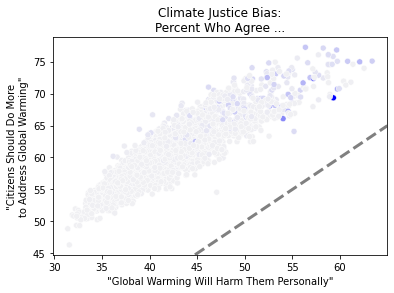

In [67]:
cmap = sns.color_palette("light:b", as_cmap=True)
chart = sns.scatterplot(data=opinions, 
                        x='personal', y='citizens',
                        hue='TotalPop', palette=cmap)
chart.axes.axline((50,50), slope=1, ls='--', linewidth=3, c='grey')
# chart.set(xlim=[0,100], ylim=[0,100])
chart.set(title='Climate Justice Bias:\nPercent Who Agree ...',
        xlabel='"Global Warming Will Harm Them Personally"',
        ylabel='"Citizens Should Do More\nto Address Global Warming"')
# chart.legend(title='Population (M)')
chart.legend([], [], frameon=False)

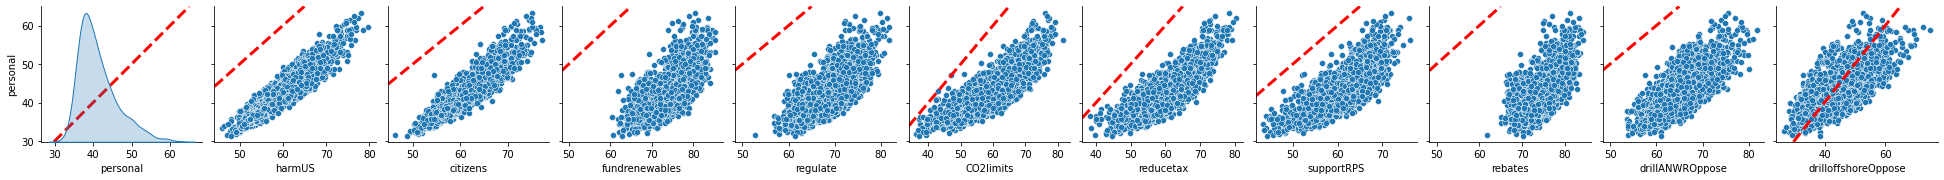

In [9]:
chart = sns.pairplot(data=opinions[['personal', 'harmUS', 'citizens'] + policies],
        y_vars='personal',kind='scatter', diag_kind='kde')
for ax in chart.axes.ravel():
    ax.axline((50,50), slope=1, ls='--', linewidth=3, c='red')

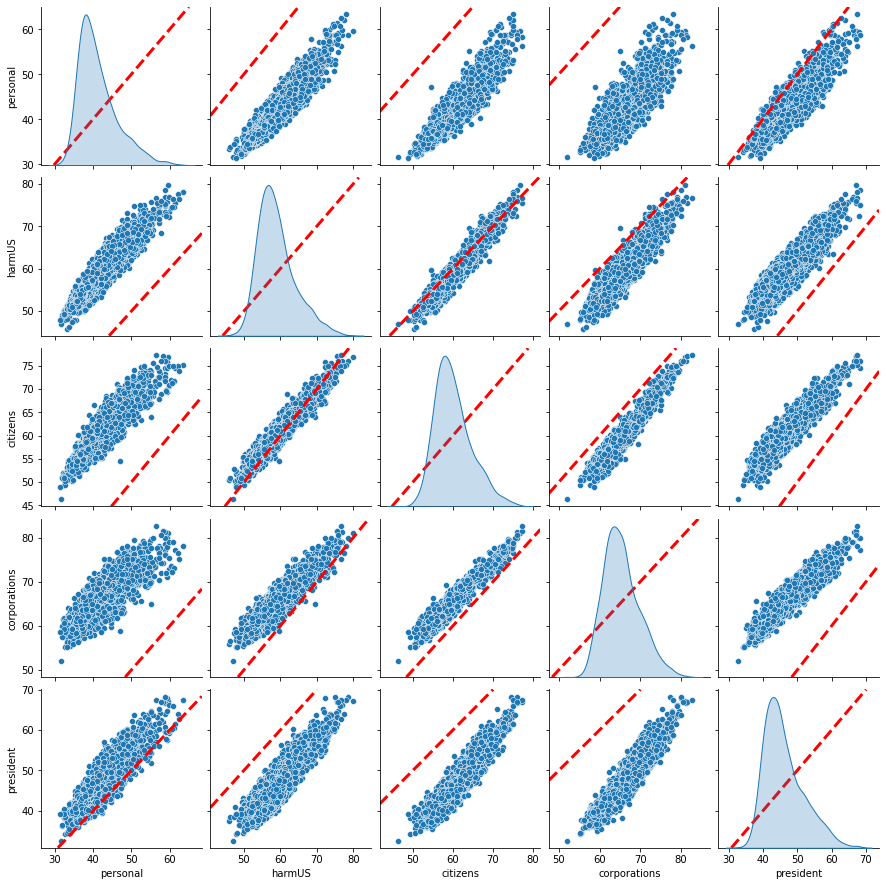

In [10]:
chart = sns.pairplot(data=opinions[['personal', 'harmUS', 'citizens', 'corporations', 'president']],
        kind='scatter', diag_kind='kde')
for ax in chart.axes.ravel():
    ax.axline((50,50), slope=1, ls='--', linewidth=3, c='red')

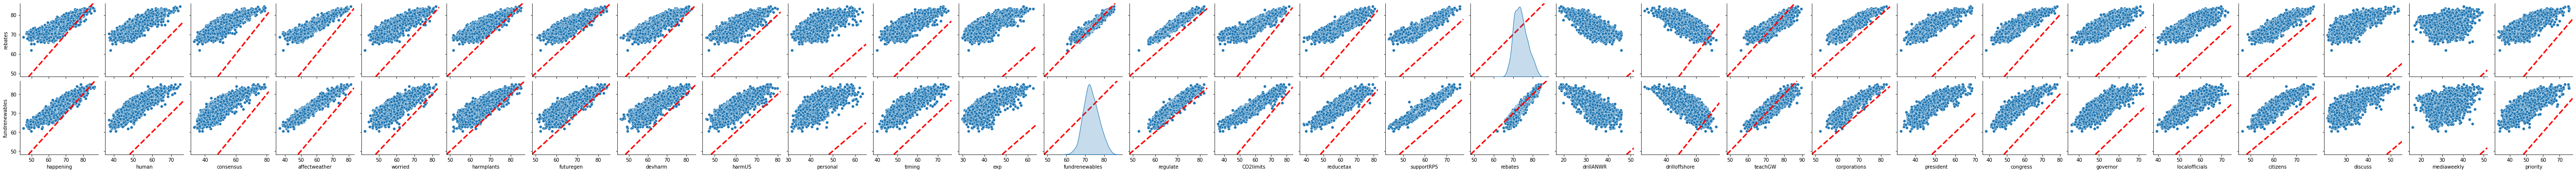

In [11]:
chart = sns.pairplot(data=opinions[questions], y_vars=['rebates','fundrenewables'],
        kind='scatter', diag_kind='kde')
for ax in chart.axes.ravel():
    ax.axline((50,50), slope=1, ls='--', linewidth=3, c='red')

In [ ]:
leveled_opinions = opinions.transform

In [103]:
# Test the question correlation
yy, xx, alphas, betas, rs = [], [], [], [], []
for qa in [q for q in questions if 'drill' not in q] + ['drillANWROppose','drilloffshoreOppose']:
    for qb in [q for q in questions if 'drill' not in q] + ['drillANWROppose','drilloffshoreOppose']:
        if qa == qb:
            continue
        leveled_y = pd.Series(opinions.loc[:, qa] - opinions.loc[:, qb], name=qa)
        yy.append(qa)
        xx.append(qb)
        alphas.append(leveled_y.mean())
        # rs.append(res.rsquared)
opinion_pairs = pd.concat([pd.Series(yy,name='y'),
                            pd.Series(xx,name='x'),
                            pd.Series(alphas,name='alpha')], axis=1)

In [108]:
# Test the question correlation
yy, xx, alphas, betas, rs = [], [], [], [], []
for qa in [q for q in questions if 'drill' not in q] + ['drillANWROppose','drilloffshoreOppose']:
    for qb in [q for q in questions if 'drill' not in q] + ['drillANWROppose','drilloffshoreOppose']:
        if qa == qb:
            continue
        formula = "{} ~ {}".format(qa, qb)
        # leveled_y = pd.Series(opinions.loc[:, qa] - opinions.loc[:, qb], name=qa)
        # leveled_opinions = pd.concat([leveled_y, opinions[qb]], axis=1)
        y, X = dmatrices(formula, data=opinions, return_type='dataframe')
        mod = sm.OLS(y, X)
        res = mod.fit()
        yy.append(qa)
        xx.append(qb)
        alphas.append(res.params[0])
        betas.append(res.params[1])
        # rs.append(res.rsquared)
opinion_pairs = pd.concat([pd.Series(yy,name='y'),
                            pd.Series(xx,name='x'),
                            pd.Series(alphas,name='alpha'),
                            pd.Series(betas,name='beta')], axis=1)

In [109]:
popular = opinion_pairs.groupby('y').mean().assign(absalpha = lambda x: np.abs(x['alpha'])).sort_values('absalpha', ascending=False).head(7)
unpopular = opinion_pairs.groupby('y').mean().assign(absalpha = lambda x: np.abs(x['alpha'])).sort_values('absalpha', ascending=False).tail(7)
agreement = opinion_pairs.groupby('y').mean().assign(absbeta = lambda x: np.abs(x['beta'])).sort_values('absbeta', ascending=False).head(7)
disagreement = opinion_pairs.groupby('y').mean().assign(absbeta = lambda x: np.abs(x['beta'])).sort_values('absbeta', ascending=False).tail(7)

In [110]:
pd.concat([popular, unpopular], axis=1)

,alpha,beta,absalpha,alpha,beta,absalpha
y,,,,,,
rebates,45.215995,0.504509,45.215995,NaN,NaN,NaN
fundrenewables,38.339988,0.613588,38.339988,NaN,NaN,NaN
regulate,28.364797,0.675341,28.364797,NaN,NaN,NaN
drillANWROppose,28.240498,0.646262,28.240498,NaN,NaN,NaN
corporations,24.385968,0.721171,24.385968,NaN,NaN,NaN
teachGW,24.150587,0.845759,24.150587,NaN,NaN,NaN
citizens,16.531238,0.765185,16.531238,NaN,NaN,NaN
governor,NaN,NaN,NaN,3.582462,0.805505,3.582462
worried,NaN,NaN,NaN,-3.430093,1.073146,3.430093


In [111]:
pd.concat([agreement, disagreement], axis=1)

,alpha,beta,absbeta,alpha,beta,absbeta
y,,,,,,
CO2limits,-11.016214,1.200007,1.200007,NaN,NaN,NaN
consensus,-16.067699,1.153281,1.153281,NaN,NaN,NaN
affectweather,-8.401482,1.138881,1.138881,NaN,NaN,NaN
priority,-15.572979,1.096969,1.096969,NaN,NaN,NaN
worried,-3.430093,1.073146,1.073146,NaN,NaN,NaN
drilloffshoreOppose,-15.301095,1.020534,1.020534,NaN,NaN,NaN
reducetax,0.334175,1.012410,1.012410,NaN,NaN,NaN
corporations,NaN,NaN,NaN,24.385968,0.721171,0.721171
discuss,NaN,NaN,NaN,-8.968363,0.692109,0.692109


In [16]:
popular = opinion_pairs.assign(absalpha = np.abs(opinion_pairs['alpha'])).sort_values(by='absalpha', ascending=False)
ignore_questions = ['drilloffshore','drillANWR', 'notmyproblem','notonmyhead','marx','laissezfaire']
tmp = tmp.loc[(~tmp['y'].isin(ignore_questions)) & (~tmp['x'].isin(ignore_questions))]
divergent = tmp.head(5)
divergent_questions = pd.concat([divergent['y'],divergent['x']]).unique()
chart = sns.pairplot(data=opinions[divergent_questions], kind='scatter', diag_kind='kde')
for ax in chart.axes.ravel():
    ax.axline((50,50), slope=1, ls='--', linewidth=3, c='red')

NameError: name 'tmp' is not defined

## Analysis 2: Suffrage



This dataset are voting rates from the 2020 Presidential Election, as collates by NYT.

https://github.com/TheUpshot/presidential-precinct-map-2020

In [ ]:
elections = gpd.read_file('precincts-with-results.geojson')

In [ ]:
elections = elections.assign(
    CountyFIPS = elections['GEOID'].str.slice(0,5),
    StateFIPS = elections['GEOID'].str.slice(0,2).str.pad(5,'right','0'))

In [ ]:
# Aggregate from the precinct level to the county level
e_by_c = elections.drop('geometry',axis=1) \
    .groupby(['StateFIPS','CountyFIPS']).sum() \
    .assign(dem_lead = lambda x: x['votes_dem'] - x['votes_rep'],
        pct_dem_lead = lambda x: 100 * x['dem_lead'] / x['votes_total'])
state_idx = e_by_c.index.get_level_values('StateFIPS')
county_idx = e_by_c.index.get_level_values('CountyFIPS')
county_elections = e_by_c.loc[state_idx != county_idx].reset_index()

In [ ]:
def regression(y, xs, data, verbose=False, center=False, weights=None):
    if center:
        xs = ["standardize({})".format(x) for x in xs]
    formula = "{} ~ {}".format(y, " + ".join(xs))
    y, X = dmatrices(formula, data=data, return_type='dataframe')
    if weights is not None:
        mod = sm.WLS(y, X, weights=weights)
    else:
        mod = sm.OLS(y, X)
    res = mod.fit()
    data = data.assign(resid = res.resid)
    print("R-Squared: {}".format(res.rsquared))
    print("F Stat: {} and F p-value: {}".format(res.fvalue, res.f_pvalue))
    if verbose:
        print(res.summary())
    return data

def twostage_regression(y, xs, fes, data, verbose=False, center=False):
    data = regression(y, fes, data, False)
    data = regression('resid', xs, data, True, center)
    return data

In [ ]:
def plot_resid(xs, resid_data):
    sns.pairplot(data=resid_data, x_vars=xs, y_vars='resid')

## Analysis: Urban

Data is from the Census urban and rural areas. It is for 2010 because the 2020 is not available yet.

https://www.census.gov/programs-surveys/geography/guidance/geo-areas/urban-rural/2010-urban-rural.html

In [ ]:
urban = pd.read_excel('PctUrbanRural_County.xls')

In [ ]:
urban = urban.assign(
    CountyFIPS = lambda x: (x['STATE']*1000 + x['COUNTY']).astype('str').str.pad(5, 'left','0'),
    StateFIPS = lambda x: x['CountyFIPS'].str.slice(0,2).str.pad(5, 'right','0'))

In [ ]:
county_urban = urban.loc[urban['StateFIPS'] != urban['CountyFIPS']]

## Analysis: Wages

From the Bureau of Economic Analysis

https://apps.bea.gov/regional/downloadzip.cfm

In [ ]:
def stack(dataset):
    # Fix data format
    # Clean up encoding error in one file.
    with open(dataset + "/" + dataset + '_NM_2001_2020.csv', 'r', 
        encoding="latin-1", errors="surrogateescape") as f:
        data = f.read()
    with open(dataset + "/" + dataset + '_NM_2001_2020.csv.new', 'w', 
          encoding="utf-8-sig", errors="surrogateescape") as f:
        f.write(data)
    # Combine all state datas together
    state_data = []
    for f in os.listdir(dataset):
        if f == dataset + '_NM_2001_2020.csv':
            pass # bad version of NM file
        elif re.match(dataset + "_[A-Z]{2}_2001_2020.csv", f):
            # pattern will match cleaned NM file
            state_data.append(pd.read_csv(dataset + "/" + f, 
                            skipfooter=4, engine='python', 
                            on_bad_lines='skip'))
    return pd.concat(state_data, ignore_index=True)

In [ ]:
wages = stack('CAINC5N')

In [ ]:
# Subset just the money
wages = wages.loc[wages['Unit'] == 'Thousands of dollars']

In [ ]:
def reshape_bea(val_name, data):
    # Clean and reshape data
    irrelevant = ['GeoName', 'Region', 'TableName', 
                'LineCode', 'Description', 'Unit']
    data = data.drop(irrelevant, axis=1) \
        .melt(id_vars=['GeoFIPS','IndustryClassification'],
            var_name='Year', value_name=val_name) \
        .assign(
            CountyFIPS = lambda x: x['GeoFIPS'].str.strip(' "'),
            StateFIPS = lambda x: x['CountyFIPS'].str.slice(0,2).str.pad(5, 'right','0'),
            NAICS = lambda x: x['IndustryClassification'].str.strip(' "'),
            Year = lambda x: x['Year'].str.strip(' "'))
    data[val_name] = data[val_name].str.strip(' "')
    return data

In [ ]:
yearwages = reshape_bea('Money', wages)

In [ ]:
def censor_bea(val_name, data):
    # Discard un-reported rows and convert dtype
    disclosed = data.loc[(data[val_name] != "(D)") & (data[val_name] != "(NA)")]
    disclosed = disclosed.astype({val_name:'float'})
    # Discard industry aggregates
    predicate = (disclosed['NAICS'] != '...') \
            & (~disclosed['NAICS'].str.contains('-')) \
            & (disclosed['NAICS'].str.len() == 2)
    # Discard non-county stuff
    predicate_ = (disclosed['CountyFIPS'] != disclosed['StateFIPS'])
    return disclosed.loc[predicate & predicate_]


In [ ]:
completeyearwages = censor_bea('Money',yearwages)

In [ ]:
def stats_bea(val_name, data):
    # Compute stats on jobs in each geo
    geo_sums = data.groupby(['StateFIPS','CountyFIPS']).sum().rename({'sum':val_name})
    geo_ind_sums = data.groupby(['StateFIPS','CountyFIPS','NAICS']).sum()
    geo_ind_pct = geo_ind_sums / geo_sums
    geo_sum = geo_sums[val_name].rename(val_name + '_sum')
    geo_std = geo_ind_pct.groupby(['StateFIPS','CountyFIPS'])[val_name].std().rename(val_name + '_std')
    geo_max = geo_ind_pct.groupby(['StateFIPS','CountyFIPS'])[val_name].max().rename(val_name + '_max')
    geo_max_ind_ = geo_ind_pct.groupby(['StateFIPS','CountyFIPS'])[val_name].idxmax()
    geo_max_ind = geo_ind_sums.loc[geo_max_ind_].reset_index('NAICS')['NAICS']
    # states = pd.Series(geo_sums.index.get_level_values('StateFIPS'), name='StateFIPS')
    # counties = pd.Series(geo_sums.index.get_level_values('CountyFIPS'), name='CountyFIPS')
    wide = pd.concat([geo_sum, geo_std, geo_max, geo_max_ind], axis=1)
    return wide.reset_index()

In [ ]:
wage_dominance = stats_bea('Money', completeyearwages)

## Analysis: Jobs

In [ ]:
jobs = stack('CAEMP25N')

In [ ]:
yearjobs = reshape_bea('Jobs', jobs)

In [ ]:
completeyearjobs = censor_bea('Jobs',yearjobs)

In [ ]:
job_dominance =  stats_bea('Jobs',completeyearjobs)

## Analysis: Cars

In [ ]:
carflow = pd.read_csv('table-2-county-to-county-commuting-flows-by-travel-mode-acs-2009-2013-noheader.csv',header=[0,1])

/Users/eric/miniconda3/envs/climate/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Fix Column types
header1 = carflow.columns.get_level_values(0).str.strip()
header2 = carflow.columns.get_level_values(1).str.strip()
carflow.columns = header1.str.cat(header2, sep='--')
carflow['Commuting Flow--Workers in Commuting Flow'] = pd.to_numeric(carflow['Commuting Flow--Workers in Commuting Flow'].str.replace(',',''))

In [ ]:
# Compute percentage car drivers
bymode = carflow.groupby(['Residence--State FIPS Code', 'Residence--County FIPS Code', 'Commuting Flow--Travel Mode'])
byorigin = carflow.groupby(['Residence--State FIPS Code', 'Residence--County FIPS Code'])
num = bymode.sum()['Commuting Flow--Workers in Commuting Flow']
denom = byorigin.sum()['Commuting Flow--Workers in Commuting Flow']
pct_mode = num / denom
cars = pct_mode.loc[pct_mode.index.get_level_values('Commuting Flow--Travel Mode') == 'Car, truck, or van: Drove alone']

In [ ]:
# Reformat to match other tables
cars = cars.reset_index().drop('Commuting Flow--Travel Mode', axis=1) \
    .rename(columns={'Residence--State FIPS Code':'StateFIPS', 
            'Residence--County FIPS Code':'CountyFIPS',
            'Commuting Flow--Workers in Commuting Flow':'pct_car'}) \
    .assign(
        CountyFIPS = lambda x: ((x['StateFIPS'].astype('int') * 1000) + x['CountyFIPS'].astype('int')).astype('str').str.pad(5, 'left', '0'),
        StateFIPS = lambda x: (x['StateFIPS'].astype('int') * 1000).astype('str').str.pad(5, 'left', '0')
    )

## Analysis: All Together

In [ ]:
covariates = opinions.merge(county_elections, on=['StateFIPS','CountyFIPS'])
covariates = covariates.merge(county_urban,  on=['StateFIPS', 'CountyFIPS'])
covariates = covariates.merge(cars,  on=['StateFIPS', 'CountyFIPS'])
covariates = covariates.merge(wage_dominance,  on=['StateFIPS', 'CountyFIPS'])
covariates = covariates.merge(job_dominance,  on=['StateFIPS', 'CountyFIPS', 'NAICS'])

In [ ]:
from scipy.stats import zscore
std_covs = covariates.assign(
    logjobs = np.log(covariates['Jobs_sum']),
    logwage = np.log(covariates['Money_sum']),
    logvotes = np.log(covariates['votes_total']),
    logjobs_z = zscore(np.log(covariates['Jobs_sum'])),
    logwage_z = zscore(np.log(covariates['Money_sum'])),
    logvotes_z = zscore(np.log(covariates['votes_total'])),
    Jobs_std_z = zscore(covariates['Jobs_std']),
    Jobs_max_z = zscore(covariates['Jobs_max']),
    Money_std_z = zscore(covariates['Money_std']),
    Money_max_z = zscore(covariates['Money_max']),
    pct_dem_lead_z = zscore(covariates['pct_dem_lead']),
    pct_car_z = zscore(covariates['pct_car']),
    POPPCT_URBA_z = zscore(covariates['POPPCT_URBAN']),
)

xs = ['logjobs','Jobs_std','Jobs_max','logwage','Money_std','Money_max', 'pct_dem_lead', 'pct_car', 'logvotes', 'POPPCT_URBAN']
zs = [z for z in std_covs.columns if '_z' in z]

### Findings

#### NotMyProblem: personal - harmUS

design | rsquared
---- | ----
xs | .19
fe | .808
x + fe | .823
fe -> x | .063

#### NotOnMyHead: personal - citizens

design | rsquared
---- | ----
xs | .14
fe | .569
x + fe | .628
fe -> x | .113


#### Marx: corporations - citizens

design | rsquared
---- | ----
xs | .124
fe | .479
x + fe | .565
fe -> x | .116


#### Laxy: corporations - president

design | rsquared
---- | ----
xs | .339
fe | .601
x + fe | .79
fe -> x | .336


#### harmUS:

design | rsquared
---- | ----
xs | .788
fe | .398
x + fe | .859
fe -> x | .516

#### citizens:

design | rsquared
---- | ----
xs | .842
fe | .368
x + fe | .864
fe -> x | .519


#### personal:

design | rsquared
---- | ----
xs | .692
fe | .333
x + fe | .831
fe -> x | .511



### Single Stage on Xs

In [ ]:
reg_data = regression(policies[3], zs, std_covs, verbose=True, center=False)

R-Squared: 0.848730183056588
F Stat: 848.3384608455096 and F p-value: 0.0
                            OLS Regression Results                            
Dep. Variable:              reducetax   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     848.3
Date:                Sat, 12 Mar 2022   Prob (F-statistic):               0.00
Time:                        20:45:53   Log-Likelihood:                -3635.0
No. Observations:                1523   AIC:                             7292.
Df Residuals:                    1512   BIC:                             7351.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

In [ ]:
# sns.pairplot(data=std_covs, x_vars=zs, y_vars='laissezfaire')

### Single Stage on State FE

In [ ]:
reg_data = regression('personal', ['StateFIPS'], std_covs, verbose=True, center=False)

R-Squared: 0.33289133178599983
                            OLS Regression Results                            
Dep. Variable:               personal   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     17.66
Date:                Sat, 12 Mar 2022   Prob (F-statistic):          3.37e-111
Time:                        16:22:12   Log-Likelihood:                -4791.6
No. Observations:                1675   AIC:                             9677.
Df Residuals:                    1628   BIC:                             9932.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Inter

### Singel Stage on both

In [ ]:
reg_data = regression('personal', zs + ['StateFIPS'], std_covs, verbose=False, center=False)

R-Squared: 0.830911980225221


### Two Stage State FE then Xs

In [ ]:
reg_data = twostage_regression('personal', zs, ['StateFIPS'], std_covs)

R-Squared: 0.33289133178599983
R-Squared: 0.5109031325461151
                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     173.8
Date:                Sat, 12 Mar 2022   Prob (F-statistic):          5.22e-250
Time:                        16:02:11   Log-Likelihood:                -4192.6
No. Observations:                1675   AIC:                             8407.
Df Residuals:                    1664   BIC:                             8467.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

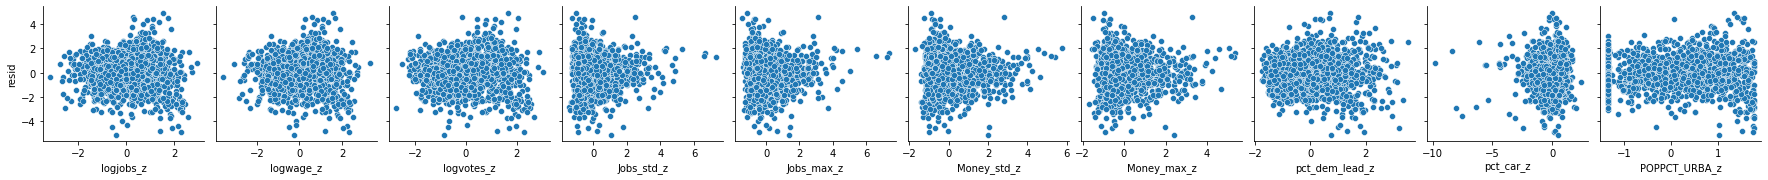

In [ ]:
sns.pairplot(data=reg_data, x_vars=zs, y_vars='resid')

## Weighted Analysis

In [ ]:
reg_data = regression('notmyproblem', zs, std_covs, verbose=True, center=False, weights=std_covs['TotalPop'])

R-Squared: 0.2708079762605444
                            WLS Regression Results                            
Dep. Variable:           notmyproblem   R-squared:                       0.271
Model:                            WLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     56.15
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           1.53e-96
Time:                        19:19:06   Log-Likelihood:                -4188.0
No. Observations:                1523   AIC:                             8398.
Df Residuals:                    1512   BIC:                             8457.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept     

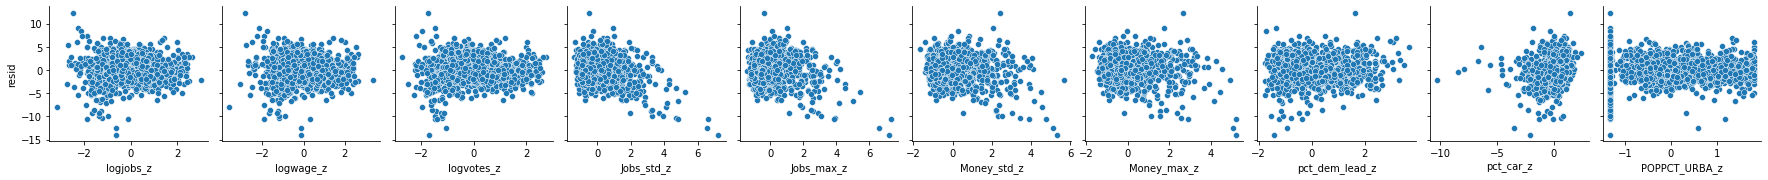

In [ ]:
sns.pairplot(data=reg_data, x_vars=zs, y_vars='resid')

In [ ]:
reg_data = regression('notmyproblem', zs, std_covs, verbose=True, center=False)

R-Squared: 0.19290206191119785
                            OLS Regression Results                            
Dep. Variable:           notmyproblem   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     36.14
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           8.45e-64
Time:                        19:19:25   Log-Likelihood:                -3198.2
No. Observations:                1523   AIC:                             6418.
Df Residuals:                    1512   BIC:                             6477.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept    

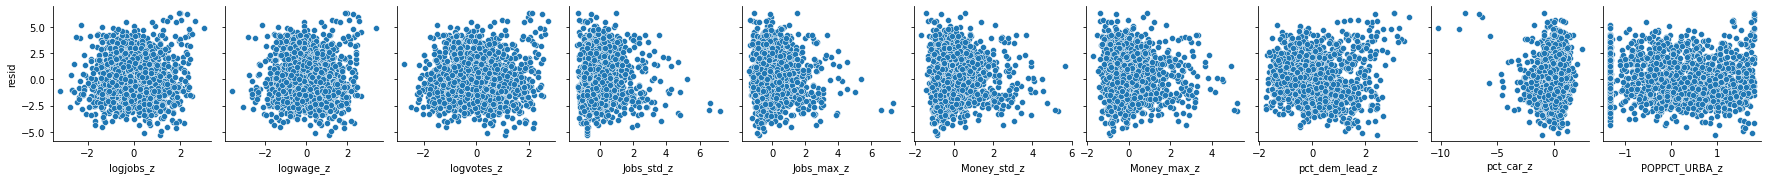

In [ ]:
sns.pairplot(data=reg_data, x_vars=zs, y_vars='resid')

In [ ]:
reg_data = regression('notmyproblem', zs, std_covs, verbose=False, center=False)
reg_data['residsq'] = reg_data['resid'] * reg_data['resid']
reg_data_bp = regression('residsq',['Jobs_std_z'], reg_data)

R-Squared: 0.19290206191119785
F Stat: 36.13785934088707 and F p-value: 8.44980329356065e-64
R-Squared: 0.0013469894777186076
F Stat: 2.0515343908477246 and F p-value: 0.15225835463097898
